# ***Tensorflow implementation of Deep Convolutional GAN***

***Importing libraries & frameworks***

In [ ]:
# import libraries and frameworks
from tensorflow.keras import layers 
from tensorflow.keras.utils import plot_model
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np 
import time
from IPython import display

***Loading the Dataset***

In [ ]:
# Load MNIST Dataset
from tensorflow.keras.datasets.mnist import load_data

# Split the dataset 
(train_X,train_y), (test_X,test_y) = load_data()

# Shape of Dataset
print('Training Dataset : ',train_X.shape,train_y.shape)
print('Testing Dataset  : ',test_X.shape,test_y.shape)

11501568/11490434 [==============================] - 0s 0us/step
Training Dataset :  (60000, 28, 28) (60000,)
Testing Dataset  :  (10000, 28, 28) (10000,)


***Displaying few samples***

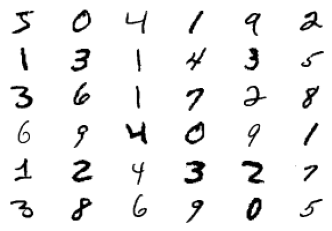

In [ ]:
for i in range(36):
  plt.subplot(6,6,1+i)
  plt.axis("off")
  plt.imshow(train_X[i], cmap = 'gray_r')
plt.show()

***Pre-processing & Loading***

In [ ]:
# Re-shaping the array to 4D
# Values are to be float
train_X = train_X.reshape(train_X.shape[0],28,28,1).astype('float32')

# Dimensions of input image is 28 * 28 and it is Grayscale
input_shape = (28,28,1)

# Normalizing to values between [-1,1]
train_X = (train_X - 127.5)/127.5

# Buffer & Batch Size
buffer_size = 60000
batch_size = 256

# Shuffle & obtain Final Dataset
td = tf.data.Dataset.from_tensor_slices(train_X).shuffle(buffer_size).batch(batch_size)

***Generator***

In [ ]:
# generator takes a vector of size 100 and reshape that into (7, 7, 128) vector
# input dimensions - 7*7*256 
# outputs dimensions - 28×28, grayscale image which is fake  
# transpose convolution in combination with batch normalization is applied. 

def Generator():

    model = tf.keras.Sequential()

    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 
    model.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

   # upsample to 14x14
    model.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # upsample to 28x28
    model.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    model.summary()
    plot_model(model, to_file='model_gen.png')
    return model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_12 (Bat  (None, 12544)            50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 7, 7, 128)        819200    
 Transpose)                                                      
                                                                 
 batch_normalization_13 (Bat  (None, 7, 7, 128)       

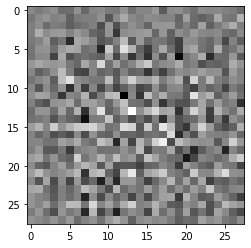

In [ ]:
# sample image generated by the the generator
generator = Generator()

noise = tf.random.normal([1, 100]) #latent space
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

***Discriminator***

In [ ]:
# Input to discriminator = 28*28*1   grayscale image. 
# Output  binary prediction (image is real (class=1) or fake (class=0))
# no pooling layers  
# single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake. 
# Downsampling from 28×28 to 14×14, then to 7×7, before the model makes an output prediction

def Discriminator():

    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(filters = 64, kernel_size = (5, 5), strides = (2, 2), padding='same',input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(filters = 128, kernel_size = (5, 5), strides = (2, 2), padding='same')) 
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())  # classifier real (class=1) or fake (class=0))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    plot_model(model, to_file='model_disc.png')
    return model

In [ ]:
# Untrained discriminator to classify between real and fake
discriminator = Discriminator()
classify = discriminator(generated_image)
print (classify)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_17 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_18 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [ ]:
# Compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)  # predictions on real images to ones
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # predictions on fake images to zeroes
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output) # predictions of discriminator on fake images as real

In [ ]:
# Discriminator and Generator optimizers
# Adam optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

***Training***

In [ ]:
epochs = 100 #maximum number of iterations
noise_dim = 100
num_output = 16
seed = tf.random.normal([num_output, noise_dim])

In [ ]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    display_gen_image(generator,epoch+1,seed)

    print ('Time for epoch {} is {} seconds'.format(epoch + 1, time.time()-start))

  # Final epoch
  display.clear_output(wait=True)
  display_gen_image(generator,epoch,seed)

***Display Generated Images***

In [ ]:
def display_gen_image(model,epoch,test_input):

  # Training is set 'False', so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.show()

***Output***

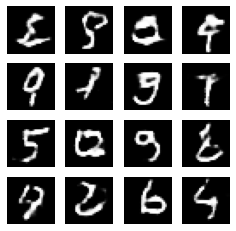

In [ ]:
train(td, epochs)